# Creating training data
This notebook is an example of how to create a training dataset for the reinforcement learning agent.

First, let's include the libraries we need.

In [1]:
import pandas as pd
import numpy as np
import ta
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import mixture as mix
from preprocessing.features import add_indicators
from sklearn.preprocessing import MinMaxScaler

Now read the OHLC data for the EURUSD forex pair from the csv file.

In [3]:
print("Loading data...")
df = pd.read_csv('data/EURUSD_M15.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')

print(f'Found {len(df)} entries...')

Loading data...
Found 102352 entries...


The data now looks like this:

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2016-01-03 23:00:00,1.08732,1.08732,1.08663,1.08670,318
1,2016-01-03 23:15:00,1.08670,1.08714,1.08661,1.08674,183
2,2016-01-03 23:30:00,1.08674,1.08708,1.08673,1.08676,245
3,2016-01-03 23:45:00,1.08678,1.08686,1.08662,1.08665,230
4,2016-01-04 00:00:00,1.08665,1.08666,1.08523,1.08577,1357


## Preprocessing the data and adding features

The first thing we do is to use fractional differencing to make the time series stationary. A good explanation of fractional differencing and why to use it is available in the article by Ritchie Ng [RAPID Fractional Differencing to Minimize Memory Loss While Making a Time Series Stationary](https://medium.com/rapids-ai/rapid-fractional-differencing-to-minimize-memory-loss-while-making-a-time-series-stationary-2052f6c060a).

The code used here is taken from the notebook linked in that article: https://github.com/ritchieng/fractional_differencing_gpu/blob/master/notebooks/gpu_fractional_differencing.ipynb

In [5]:
train_data = df.copy()

In [6]:
def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.

    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1

    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)

        k += 1

    w_k = w_k.reshape(-1, 1)

    return w_k


def frac_diff(df, d=0.8, floor=1e-5):
    r"""Fractionally difference time series via CPU.

    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)

    # Reverse weights
    weights = weights[::-1]

    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())

    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)

    return df_fd

In [7]:
d=0.6
floor=1e-4

train_data['CFD'] = np.nan
cfd = frac_diff(pd.DataFrame(df['Close']), d, floor)
offset = (len(df) - len(cfd))
train_data.loc[offset:, ['CFD']] = cfd[0].values

train_data['OFD'] = np.nan
ofd = frac_diff(pd.DataFrame(df['Open']), d, floor)
train_data.loc[offset:, ['OFD']] = ofd[0].values

train_data['HFD'] = np.nan
hfd = frac_diff(pd.DataFrame(df['High']), d, floor)
train_data.loc[offset:, ['HFD']] = hfd[0].values

train_data['LFD'] = np.nan
lfd = frac_diff(pd.DataFrame(df['Low']), d, floor)
train_data.loc[offset:, ['LFD']] = lfd[0].values

train_data['VFD'] = np.nan
lfd = frac_diff(pd.DataFrame(df['Volume']), d, floor)
train_data.loc[offset:, ['VFD']] = lfd[0].values

In [9]:
train_data = train_data.dropna().reset_index(drop=True)

In [10]:
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,VFD
0,2016-01-05 10:00:00,1.07895,1.07985,1.07858,1.07866,4842,0.023512,0.024194,0.024090,0.023243,1455.202210
1,2016-01-05 10:15:00,1.07867,1.07917,1.07826,1.07896,4468,0.023996,0.023517,0.024086,0.024257,625.872238
2,2016-01-05 10:30:00,1.07896,1.07898,1.07725,1.07797,5367,0.024666,0.024006,0.023834,0.024132,184.954704
3,2016-01-05 10:45:00,1.07797,1.07811,1.07725,1.07734,4330,0.023635,0.024660,0.024181,0.023425,1245.985248
4,2016-01-05 11:00:00,1.07735,1.07850,1.07647,1.07723,7406,0.023649,0.023634,0.023581,0.024142,-330.415395


Now that we have a stationary time series we add the first features. These are features directly taken from the date / time information of the series.

In [11]:
train_data['moh'] = train_data['Date'].dt.minute

In [12]:
train_data['hod'] = train_data['Date'].dt.hour

In [13]:
train_data['dow'] = train_data['Date'].dt.dayofweek

In [14]:
train_data['woy'] = train_data['Date'].dt.week
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,VFD,moh,hod,dow,woy
0,2016-01-05 10:00:00,1.07895,1.07985,1.07858,1.07866,4842,0.023512,0.024194,0.024090,0.023243,1455.202210,0,10,1,1
1,2016-01-05 10:15:00,1.07867,1.07917,1.07826,1.07896,4468,0.023996,0.023517,0.024086,0.024257,625.872238,15,10,1,1
2,2016-01-05 10:30:00,1.07896,1.07898,1.07725,1.07797,5367,0.024666,0.024006,0.023834,0.024132,184.954704,30,10,1,1
3,2016-01-05 10:45:00,1.07797,1.07811,1.07725,1.07734,4330,0.023635,0.024660,0.024181,0.023425,1245.985248,45,10,1,1
4,2016-01-05 11:00:00,1.07735,1.07850,1.07647,1.07723,7406,0.023649,0.023634,0.023581,0.024142,-330.415395,0,11,1,1


The next features added to the data are technical indicators. To keep things simple we use the `add_all_ta_features` function from the `ta` library we included at the beginning.

In [15]:
train_data = ta.add_all_ta_features(train_data, open="Open", high="High", low="Low", close="Close", volume="Volume")
train_data.head()

G:\dev\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
G:\dev\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
G:\dev\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
G:\dev\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
G:\dev\Anaconda3\lib\site-packages\ta\trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2016-01-05 10:00:00,1.07895,1.07985,1.07858,1.07866,4842,0.023512,0.024194,0.024090,0.023243,...,0.000000,-100.000000,0.145952,6.299213,6.299213,-93.700787,0.0,-4.829083,NaN,0.000000
1,2016-01-05 10:15:00,1.07867,1.07917,1.07826,1.07896,4468,0.023996,0.023517,0.024086,0.024257,...,47.986009,-99.606863,1.399795,44.025157,25.162185,-55.974843,0.0,0.027812,0.027808,0.027812
2,2016-01-05 10:30:00,1.07896,1.07898,1.07725,1.07797,5367,0.024666,0.024006,0.023834,0.024132,...,30.447550,-99.463637,2.610854,27.692308,26.005559,-72.307692,0.0,-0.091755,-0.091797,-0.063968
3,2016-01-05 10:45:00,1.07797,1.07811,1.07725,1.07734,4330,0.023635,0.024660,0.024181,0.023425,...,23.516435,-99.386268,2.726690,3.461538,25.059668,-96.538462,0.0,-0.058443,-0.058460,-0.122374
4,2016-01-05 11:00:00,1.07735,1.07850,1.07647,1.07723,7406,0.023649,0.023634,0.023581,0.024142,...,16.926877,-99.335965,3.894438,22.485207,17.879684,-77.514793,0.0,-0.010210,-0.010211,-0.132572


Some columns of the added technical indicators will be filled with NaNs, so let's remove these columns.

In [16]:
test = train_data[1000:]
train_data = train_data.drop(test.columns[test.isnull().any()], axis=1)
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2016-01-05 10:00:00,1.07895,1.07985,1.07858,1.07866,4842,0.023512,0.024194,0.024090,0.023243,...,0.000000,-100.000000,0.145952,6.299213,6.299213,-93.700787,0.0,-4.829083,NaN,0.000000
1,2016-01-05 10:15:00,1.07867,1.07917,1.07826,1.07896,4468,0.023996,0.023517,0.024086,0.024257,...,47.986009,-99.606863,1.399795,44.025157,25.162185,-55.974843,0.0,0.027812,0.027808,0.027812
2,2016-01-05 10:30:00,1.07896,1.07898,1.07725,1.07797,5367,0.024666,0.024006,0.023834,0.024132,...,30.447550,-99.463637,2.610854,27.692308,26.005559,-72.307692,0.0,-0.091755,-0.091797,-0.063968
3,2016-01-05 10:45:00,1.07797,1.07811,1.07725,1.07734,4330,0.023635,0.024660,0.024181,0.023425,...,23.516435,-99.386268,2.726690,3.461538,25.059668,-96.538462,0.0,-0.058443,-0.058460,-0.122374
4,2016-01-05 11:00:00,1.07735,1.07850,1.07647,1.07723,7406,0.023649,0.023634,0.023581,0.024142,...,16.926877,-99.335965,3.894438,22.485207,17.879684,-77.514793,0.0,-0.010210,-0.010211,-0.132572


In [17]:
train_data = train_data.dropna().reset_index(drop=True)
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2016-01-05 20:45:00,1.07421,1.07467,1.07414,1.07431,1269,0.025214,0.024575,0.024728,0.024911,...,44.079870,-80.907567,46.119033,77.405858,70.607508,-22.594142,-0.000313,0.010240,0.010240,-0.403278
1,2016-01-05 21:00:00,1.07432,1.07470,1.07427,1.07442,1136,0.025059,0.025224,0.025229,0.025329,...,40.174545,-79.897386,43.716050,72.077922,74.494593,-27.922078,-0.000087,0.010239,0.010239,-0.393080
2,2016-01-05 21:15:00,1.07442,1.07472,1.07438,1.07439,1226,0.025061,0.025063,0.025002,0.025167,...,43.232207,-78.933945,45.108242,70.129870,73.204550,-29.870130,0.000114,-0.002792,-0.002792,-0.395862
3,2016-01-05 21:30:00,1.07438,1.07512,1.07420,1.07501,1663,0.024937,0.025054,0.024959,0.025142,...,52.627705,-77.799752,55.339938,93.922652,78.710148,-6.077348,0.000292,0.057707,0.057691,-0.338383
4,2016-01-05 21:45:00,1.07501,1.07532,1.07475,1.07501,2143,0.025550,0.024925,0.025328,0.024855,...,58.522364,-76.717197,50.980106,84.577114,82.876545,-15.422886,0.000534,0.000000,0.000000,-0.338383


Now we have all the features added to the data. We will keep the first columns with the original data as they will be used later for the training and testing of the agent.

## Try to find regimes
The next code is used to find regimes in the time series.

In [18]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data[train_data.columns[6:]] = scaler.fit_transform(train_data[train_data.columns[6:]].values)

In [19]:
unsup = mix.BayesianGaussianMixture(n_components=3, 
                                    covariance_type='full', 
                                    weight_concentration_prior=1e-3,
                                    weight_concentration_prior_type='dirichlet_process',
                                    mean_precision_prior=1e+2,                                    
                                    n_init=10, 
                                    random_state=42,
                                    verbose=1)

In [20]:
unsup.fit(train_data[train_data.columns[6:]].values)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 5
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 6
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 7
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 8
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 9
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=100.0,
                        mean_prior=None, n_components=3, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=1,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=0.001,
                        weight_concentration_prior_type='dirichlet_process')

In [21]:
regime = unsup.predict(train_data[train_data.columns[6:]].values)

Add the predicted infos for the regime to the dataset.

In [22]:
train_data['regime'] = regime
# scale regime info: converting values [1,2,3] to [-1,0,1] to be in the range of the scaled features.
train_data['regime'] = train_data['regime'].apply(lambda x: x-1)
train_data = train_data.dropna().reset_index(drop=True)
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,regime
0,2016-01-05 20:45:00,1.07421,1.07467,1.07414,1.07431,1269,-0.120046,-0.195670,-0.259834,-0.157549,...,-1.000000,-0.109412,0.548117,0.415856,0.548117,0.225769,-0.176410,-0.169988,-0.639404,1
1,2016-01-05 21:00:00,1.07432,1.07470,1.07427,1.07442,1136,-0.130142,-0.155247,-0.225633,-0.127216,...,-0.985182,-0.177294,0.441558,0.494367,0.441558,0.236108,-0.176411,-0.169989,-0.638407,1
2,2016-01-05 21:15:00,1.07442,1.07472,1.07438,1.07439,1226,-0.130016,-0.165290,-0.241165,-0.138938,...,-0.971050,-0.137966,0.402597,0.468311,0.402597,0.245291,-0.186233,-0.179833,-0.638679,1
3,2016-01-05 21:30:00,1.07438,1.07512,1.07420,1.07501,1663,-0.138063,-0.165863,-0.244044,-0.140811,...,-0.954413,0.151069,0.878453,0.579513,0.878453,0.253460,-0.140636,-0.134141,-0.633060,1
4,2016-01-05 21:45:00,1.07501,1.07532,1.07475,1.07501,2143,-0.098219,-0.173857,-0.218885,-0.161622,...,-0.938533,0.027908,0.691542,0.663667,0.691542,0.264524,-0.184128,-0.177724,-0.633060,1


Let's take a look at some examples for the regime feature.

G:\dev\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
G:\dev\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


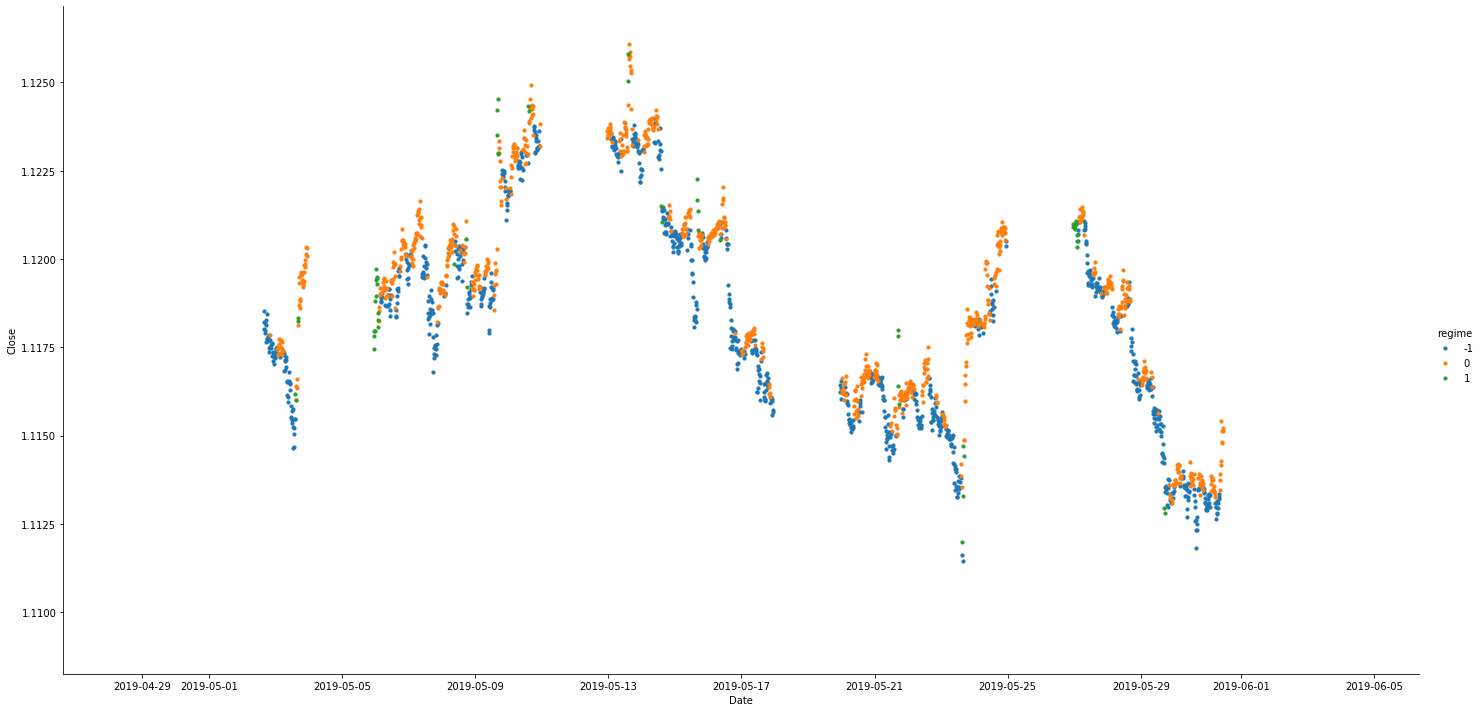

In [24]:
order=[-1,0,1]
fig = sns.FacetGrid(data=train_data[-20000:-18000],hue='regime',hue_order=order,aspect=2,size=10)
fig.map(plt.scatter,'Date','Close', s=10).add_legend()
plt.show()

In [25]:
for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variance for regime %i: '%i,(np.mean(unsup.covariances_[i])))

Mean for regime -1:  -0.036053143203322834
Co-Variance for regime -1:  0.022617306369842403
Mean for regime 0:  -0.05649177297178866
Co-Variance for regime 0:  0.011927259041213797
Mean for regime 1:  -0.02538475108395774
Co-Variance for regime 1:  0.015019752437992008


The last features that are added to the dataset are features that will be filled with values during the training process of the agent.

In [23]:
train_data['open_ratio'] = 0.0
train_data['open_pl_ratio'] = 0.0
train_data['profit_ratio'] = 0.0
train_data.head()

,Date,Open,High,Low,Close,Volume,CFD,OFD,HFD,LFD,...,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,regime,open_ratio,open_pl_ratio,profit_ratio
0,2016-01-05 20:45:00,1.07421,1.07467,1.07414,1.07431,1269,-0.120046,-0.195670,-0.259834,-0.157549,...,0.415856,0.548117,0.225769,-0.176410,-0.169988,-0.639404,1,0.0,0.0,0.0
1,2016-01-05 21:00:00,1.07432,1.07470,1.07427,1.07442,1136,-0.130142,-0.155247,-0.225633,-0.127216,...,0.494367,0.441558,0.236108,-0.176411,-0.169989,-0.638407,1,0.0,0.0,0.0
2,2016-01-05 21:15:00,1.07442,1.07472,1.07438,1.07439,1226,-0.130016,-0.165290,-0.241165,-0.138938,...,0.468311,0.402597,0.245291,-0.186233,-0.179833,-0.638679,1,0.0,0.0,0.0
3,2016-01-05 21:30:00,1.07438,1.07512,1.07420,1.07501,1663,-0.138063,-0.165863,-0.244044,-0.140811,...,0.579513,0.878453,0.253460,-0.140636,-0.134141,-0.633060,1,0.0,0.0,0.0
4,2016-01-05 21:45:00,1.07501,1.07532,1.07475,1.07501,2143,-0.098219,-0.173857,-0.218885,-0.161622,...,0.663667,0.691542,0.264524,-0.184128,-0.177724,-0.633060,1,0.0,0.0,0.0


## Save training data, regime model and scaler
In the last step everything we have done so far has to be saved to files.

First, the training data:

In [26]:
train_data.to_csv('data/training_data.csv', index=False)

Last, the regime model and the scaler that was used for scaling the features:

In [27]:
from joblib import dump

In [28]:
dump(unsup, 'regime_model.bin', compress=True)

['regime_model.bin']

In [29]:
dump(scaler, 'volume_scaler.bin', compress=True)

['volume_scaler.bin']